#### Import necessary python modules (libraries)

In [157]:
pip install kagglehub seaborn imblearn xgboost catboost scikit-optimize numpy pandas matplotlib seaborn scikit-learn scipy ydata-profiling



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [158]:
from pprint import pprint  # Pretty-print for better visualization of data structures
import numpy as np  # Numerical computing library for arrays and mathematical operations
import pandas as pd  # Data manipulation and analysis
import matplotlib.pyplot as plt  # Data visualization
import seaborn as sns  # Advanced data visualization (built on matplotlib)

# Preprocessing and splitting data
from sklearn.preprocessing import LabelEncoder  # Encoding categorical variables
from sklearn.model_selection import train_test_split  # Splitting dataset into train and test sets

# Machine learning models
from sklearn.linear_model import LogisticRegression  # Logistic Regression model
from sklearn.neighbors import KNeighborsClassifier  # k-Nearest Neighbors classifier
from sklearn.naive_bayes import GaussianNB  # Naive Bayes classifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  # Ensemble models
from xgboost import XGBClassifier  # Extreme Gradient Boosting model
from catboost import CatBoostClassifier  # CatBoost gradient boosting mode

# Metrics for model evaluation
from sklearn.metrics import (
    accuracy_score,  # Accuracy metric
    precision_score,  # Precision metric
    recall_score,  # Recall metric
    f1_score,  # F1 score metric
    confusion_matrix,  # Confusion matrix for evaluation
    roc_auc_score,  # ROC-AUC score
    classification_report  # Detailed classification report
)

# Optimization
from scipy.optimize import minimize  # Optimization library for model optimization

# Handling imbalanced datasets
from imblearn.over_sampling import SMOTE  # Synthetic Minority Oversampling Technique
from imblearn.under_sampling import RandomUnderSampler  # Random undersampling for imbalanced data

from datetime import datetime  # Date and time operations
import kagglehub  # Kaggle API for downloading datasets


### Call upon the data from Kaggle and print the path

In [159]:
# Download latest version
path = kagglehub.dataset_download("nikhil1e9/loan-default") #dataset from kaggle
data = pd.read_csv(str(path) + '/Loan_default.csv')
data.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


#### Drop Unnecessary Column LoanID as its a set of random symbols that resemble an ID

In [160]:
data = data.drop(['LoanID'], axis=1)

#### Drop Unnecessary columns (deduced from the EDA)

In [161]:
columns_to_drop = ['LoanTerm', 'NumCreditLines']
data = data.drop(columns=columns_to_drop, errors='ignore')  # errors='ignore' ensures no errors if a column is missing


#### Encode the categorical features

In [162]:
encoder = LabelEncoder()
obj_col = ['HasCoSigner','LoanPurpose','HasDependents', 'HasMortgage','MaritalStatus', 'EmploymentType', 'Education'] # these are all categorical columns
for col in obj_col:
    data[col] = encoder.fit_transform(data[col])

##### Making sure its encoded properly

In [163]:
data.dtypes

Age                 int64
Income              int64
LoanAmount          int64
CreditScore         int64
MonthsEmployed      int64
InterestRate      float64
DTIRatio          float64
Education           int64
EmploymentType      int64
MaritalStatus       int64
HasMortgage         int64
HasDependents       int64
LoanPurpose         int64
HasCoSigner         int64
Default             int64
dtype: object

#### Splitting the data into a training dataset (75% of the data is going towards training+validation and 25% is going towards testing)

In [164]:
X = data.drop(columns=['Default'])
y = data['Default']

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) # Stratification ensures that the proportion of Default is similar in both train and test datasets

Experimenting witrh different techniques to deal withe imbalance

In [166]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Create different training datasets
rus = RandomUnderSampler(random_state=42)
X_downsampled, y_downsampled = rus.fit_resample(X_train, y_train)

smote = SMOTE(random_state=42)
X_upsampled, y_upsampled = smote.fit_resample(X_train, y_train)

# Use original training data for one model
X_original, y_original = X_train, y_train


In [167]:
print("Original Training Data Shape:", X_original.shape, y_original.shape)
print("Downsampled Training Data Shape:", X_downsampled.shape, y_downsampled.shape)
print("Upsampled Training Data Shape:", X_upsampled.shape, y_upsampled.shape)

Original Training Data Shape: (191510, 14) (191510,)
Downsampled Training Data Shape: (44480, 14) (44480,)
Upsampled Training Data Shape: (338540, 14) (338540,)


#### Experimenting with traditional Machine Learning Techniques

In [168]:
# Define models
models = [
    # CatBoostClassifier(verbose=False),
    XGBClassifier(),
    # RandomForestClassifier(),
    # KNeighborsClassifier(),
    # LogisticRegression(),
    # GaussianNB()
]

In [169]:
# List to store all experiment results
experiment_results = []

# Function to adjust threshold for optimizing TN and minimizing FN
def optimize_threshold(y_true, y_probs, metric="tn_fn"):
    """
    Finds the best threshold for a given model by optimizing a custom metric.

    Parameters
    ----------
    y_true : array-like
        True labels
    y_probs : array-like
        Predicted probabilities
    metric : str, optional
        Metric to optimize, by default "tn_fn". Can be "accuracy", "tn_fn", or a custom metric.

    Returns
    -------
    best_threshold : float
        Best threshold for optimizing the chosen metric
    best_score : float
        Best score for the chosen metric
    """
    best_threshold = 0.5
    best_score = -np.inf

    for threshold in np.arange(0.0, 1.05, 0.05):  # Search thresholds from 0.0 to 1.0 in steps of 0.05
        y_pred = (y_probs >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        # Custom metric to balance TN and FN
        if metric == "tn_fn":
            score = tn - fn 
        else:
            score = accuracy_score(y_true, y_pred)

        if score > best_score: #if score is better is better than teh current best , rename the best to the new score and do teh same for the threshold
            best_score = score
            best_threshold = threshold

    return best_threshold

# Function to run experiments with threshold optimization
def run_experiment_with_cv(models, X_resampled, y_resampled, X_test, y_test):
    """
    Runs a series of experiments on a given set of models with cross-validation
    and threshold optimization.

    Parameters
    ----------
    models : list
        List of models to experiment with
    X_resampled : array-like
        Resampled training features
    y_resampled : array-like
        Resampled training labels
    X_test : array-like
        Test features
    y_test : array-like
        Test labels

    Returns
    -------
    results : list
        List of results for each model, including the model name, threshold, TN, FN, accuracy, precision, recall, F1 score, and AUC-ROC score
    """

    experiment_name = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    results = []

    for model in models:
        # Train the model on the resampled training set
        model.fit(X_resampled, y_resampled)

        # Predict probabilities on the test set
        y_test_probs = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

        # Optimize the threshold
        best_threshold = optimize_threshold(y_test, y_test_probs)

        # Make predictions with the best threshold
        y_test_pred = (y_test_probs >= best_threshold).astype(int)

        # Calculate metrics
        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_precision = precision_score(y_test, y_test_pred, zero_division=0)
        test_recall = recall_score(y_test, y_test_pred)
        test_f1 = f1_score(y_test, y_test_pred)
        test_auc = roc_auc_score(y_test, y_test_probs)

        results.append({
            "Experiment": experiment_name,
            "Model": model.__class__.__name__,
            "Threshold": best_threshold,
            "True Negatives": tn,
            "False Positives": fp,
            "False Negatives": fn,
            "True Positives": tp,
            "Test Accuracy": test_accuracy,
            "Test Precision": test_precision,
            "Test Recall": test_recall,
            "Test F1 Score": test_f1,
            "Test AUC": test_auc
        })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Save the results for this experiment
    experiment_results.append(results_df)
    results_df.to_csv(f"{experiment_name}_threshold_optimized_results.csv", index=False)
    print(f"Results saved for experiment: {experiment_name}")

    return y_test_pred

In [170]:
# Prepare the datasets
# Original dataset
X_original, y_original = X_train.copy(), y_train.copy()

# Downsampled dataset
rus = RandomUnderSampler(random_state=42)
X_downsampled, y_downsampled = rus.fit_resample(X_train, y_train)

# Upsampled dataset
smote = SMOTE(random_state=42)
X_upsampled, y_upsampled = smote.fit_resample(X_train, y_train)

In [171]:
# Function to collect predictions from multiple runs
def collect_predictions():
    """
    Collect predictions from multiple runs on the original, downsampled, and upsampled datasets.

    Returns a dictionary with the following structure:
    {
        "Original": {},
        "Downsampled": {},
        "Upsampled": {}
    }
    """
    predictions = {}

    # Original dataset
    print("\nRunning models on Original Dataset")
    predictions["Original"] = run_experiment_with_cv(models, X_original, y_original, X_test, y_test)

    # Downsampled dataset
    print("\nRunning models on Downsampled Dataset")
    predictions["Downsampled"] = run_experiment_with_cv(models, X_downsampled, y_downsampled, X_test, y_test)

    # Upsampled dataset
    print("\nRunning models on Upsampled Dataset")
    predictions["Upsampled"] = run_experiment_with_cv(models, X_upsampled, y_upsampled, X_test, y_test)

    return predictions

# Run the experiments and collect predictions
all_predictions = collect_predictions()




Running models on Original Dataset
Results saved for experiment: 2024-12-01_04-42-23

Running models on Downsampled Dataset
Results saved for experiment: 2024-12-01_04-42-23

Running models on Upsampled Dataset
Results saved for experiment: 2024-12-01_04-42-24



Optimized Ensemble Evaluation:
Optimized Weights: [0.33333333 0.33333333 0.33333333]

Confusion Matrix:
[[55879   545]
 [ 6748   665]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     56424
           1       0.55      0.09      0.15      7413

    accuracy                           0.89     63837
   macro avg       0.72      0.54      0.55     63837
weighted avg       0.85      0.89      0.85     63837



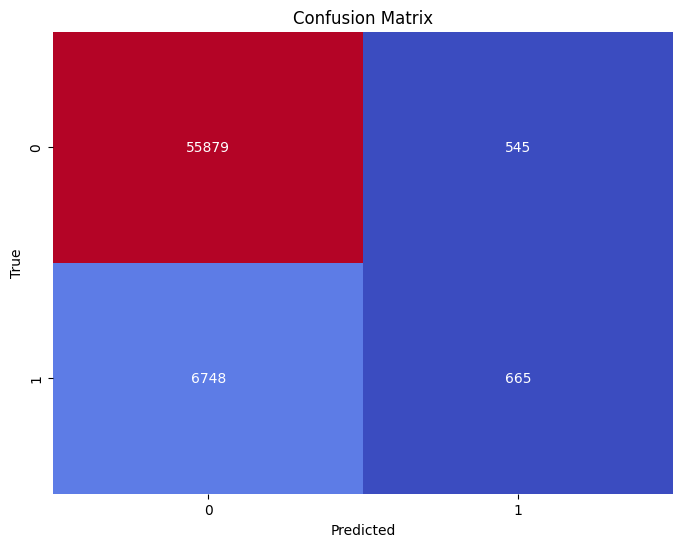

True Negatives (TN): 55879
False Negatives (FN): 6748


In [172]:
# Function to calculate True Negatives and False Negatives from the ensemble
# Optimize the weights for the ensemble
def optimize_weights(all_predictions, y_test):
    def objective(weights):
        # Calculate weighted probabilities
        weighted_probs = np.dot(weights, all_predictions)

        # Optimize threshold
        best_threshold = optimize_threshold(y_test, weighted_probs)
        y_pred = (weighted_probs >= best_threshold).astype(int)

        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        # Define custom metric: maximize TN and minimize FN
        return -(tn - fn)  # Negative to maximize

    # Initial weights (equal weights for all models)
    n_models = all_predictions.shape[0]
    initial_weights = np.ones(n_models) / n_models

    # Bounds and constraints for weights
    bounds = [(0, 1) for _ in range(n_models)]
    constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}

    # Perform optimization
    result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints)
    return result.x  # Return optimized weights
    
def calculate_tn_fn(y_test, ensemble_pred):
    """
    Calculate True Negatives and False Negatives from the ensemble predictions.

    Parameters
    ----------
    y_test : array-like
        Test labels
    ensemble_pred : array-like
        Ensemble predictions

    Returns
    -------
    tn : int
        True Negatives
    fn : int
        False Negatives
    """
    # Generate confusion matrix
    cm = confusion_matrix(y_test, ensemble_pred)
    
    # Extract True Negatives (TN) and False Negatives (FN)
    tn, fp, fn, tp = cm.ravel()
    return tn, fn

# Ensemble predictions with optimized weights and threshold
def ensemble_predictions(all_predictions, y_test):
    """
    Generate ensemble predictions with optimized weights and threshold.

    Parameters
    ----------
    all_predictions : dict
        Dictionary of predictions from different models
    y_test : array-like
        Test labels

    Returns
    -------
    ensemble_pred : array-like
        Ensemble predictions
    optimized_weights : array-like
        Optimized weights for the ensemble
    best_threshold : float
        Best threshold for the ensemble
    tn : int
        True Negatives
    fn : int
        False Negatives
    """
    # Convert all_predictions dictionary to a stacked array
    prediction_array = np.array(list(all_predictions.values()))  # Shape: (n_models, n_samples)

    # Optimize weights for the ensemble
    optimized_weights = optimize_weights(prediction_array, y_test)

    # Calculate weighted probabilities
    weighted_probs = np.dot(optimized_weights, prediction_array)

    # Optimize threshold
    best_threshold = optimize_threshold(y_test, weighted_probs)

    # Generate ensemble predictions
    ensemble_pred = (weighted_probs >= best_threshold).astype(int)

    # Evaluate the ensemble
    print("\nOptimized Ensemble Evaluation:")
    print("Optimized Weights:", optimized_weights)

    # Calculate TN and FN
    tn, fn = calculate_tn_fn(y_test, ensemble_pred)

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, ensemble_pred)
    print(cm)

    print("\nClassification Report:")
    print(classification_report(y_test, ensemble_pred))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=False,
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")

    plt.show()

    return ensemble_pred, optimized_weights, best_threshold, tn, fn


ensemble_pred, optimized_weights, best_threshold, tn, fn = ensemble_predictions(all_predictions, y_test)

# Print the TN and FN values
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")


In [173]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_net_profit(tn_count, fn_count, mu=5, sigma=1.0):
    """
    Calculate the net profit.

    Parameters:
    - tn_count: Number of true negatives (approved loans that are fine).
    - fn_count: Number of false negatives (approved loans that defaulted).
    - mu: Mean of the log-normal distribution.
    - sigma: Standard deviation of the log-normal distribution.

    Returns:
    - net_profit: The total net profit.
    """
    np.random.seed(42)
    # Income from approved loans (True Negatives)
    income = tn_count * 30

    # Loss from defaults (False Negatives)
    losses = np.random.lognormal(mean=mu, sigma=sigma, size=fn_count)

    # Ensure losses are between 50 and 1000 OMR
    losses_clipped = np.clip(losses, 50, 1000)
    total_loss = losses_clipped.sum()

    # Net profit
    net_profit = income - total_loss

    # Print details
    print(f"True Negatives (approved loans): {tn_count}")
    print(f"False Negatives (defaults): {fn_count}")
    print(f"Income from approved loans: {income:.2f} OMR")
    print(f"Total loss from defaults: {total_loss:.2f} OMR")
    print("")
    print("###"*30)
    print(" "*15, f"Net profit: {net_profit:.2f} OMR")
    print("###"*30)
    print("")


    return net_profit




net_profit = calculate_net_profit(tn, fn, mu=5, sigma=0.8)



True Negatives (approved loans): 55879
False Negatives (defaults): 6748
Income from approved loans: 1676370.00 OMR
Total loss from defaults: 1359860.58 OMR

##########################################################################################
                Net profit: 316509.42 OMR
##########################################################################################

